In [46]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

In [47]:
RAND_VAL=42
num_folds=1 ## Number of folds
n_est=6000

In [48]:
df_train = pd.read_csv('/kaggle/input/dataset13/train.csv (3)/train.csv')
df_train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [49]:
df_train.shape

(20758, 18)

In [50]:
df_test = pd.read_csv('/kaggle/input/dataset13/test.csv (2)/test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [51]:
df_train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [52]:
df_orig=pd.read_csv("/kaggle/input/dadta2/ObesityDataSet.csv")
df_orig.shape

(2111, 17)

In [53]:
df_orig.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [54]:
df_train.duplicated().sum()

0

In [55]:
df_train.shape

(20758, 18)

In [56]:
sub=pd.read_csv("/kaggle/input/dataset13/sample_submission (6).csv")


In [57]:
sub

,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight
...,...,...
13835,34593,Normal_Weight
13836,34594,Normal_Weight
13837,34595,Normal_Weight
13838,34596,Normal_Weight


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [59]:
df_train['NObeyesdad'].nunique()

7

In [60]:
df_train.nunique().sort_values(ascending=True)

Gender                                2
SCC                                   2
SMOKE                                 2
family_history_with_overweight        2
FAVC                                  2
CALC                                  3
CAEC                                  4
MTRANS                                5
NObeyesdad                            7
NCP                                 689
FCVC                                934
TUE                                1297
FAF                                1360
CH2O                               1506
Age                                1703
Height                             1833
Weight                             1979
id                                20758
dtype: int64

In [61]:
df_train.nunique().sort_values(ascending=True).keys()

Index(['Gender', 'SCC', 'SMOKE', 'family_history_with_overweight', 'FAVC',
       'CALC', 'CAEC', 'MTRANS', 'NObeyesdad', 'NCP', 'FCVC', 'TUE', 'FAF',
       'CH2O', 'Age', 'Height', 'Weight', 'id'],
      dtype='object')

In [62]:
ordinal_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Map the values using the defined mapping
df_train['NObeyesdad'] = df_train['NObeyesdad'].map(ordinal_mapping)

In [63]:
df_train['NObeyesdad']

0        3
1        1
2        0
3        6
4        3
        ..
20753    5
20754    0
20755    5
20756    3
20757    5
Name: NObeyesdad, Length: 20758, dtype: int64

In [64]:
dfo=df_train.select_dtypes(include='object')

In [65]:
dfo.nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
dtype: int64

In [66]:
dfn=df_train.select_dtypes(include= 'number')

In [67]:
dfn.columns

Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'NObeyesdad'],
      dtype='object')

In [68]:
scale_cols = ['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [69]:
df_train['CAEC'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [70]:
df_train['NObeyesdad']

0        3
1        1
2        0
3        6
4        3
        ..
20753    5
20754    0
20755    5
20756    3
20757    5
Name: NObeyesdad, Length: 20758, dtype: int64

In [71]:
df_train.shape,df_test.shape

((20758, 27), (13840, 26))

In [72]:
df_train['BMI'] = df_train['Weight'] / (df_train['Height'] ** 2)
df_train['Caloric_Intake'] = (df_train['FCVC'] + df_train['FAF']) * df_train['CH2O']
df_train['Weight_Status_Score'] = (df_train['Weight'] - df_train['Weight'].mean()) / df_train['Weight'].std()
df_train['Physical_Activity_Minutes'] = df_train['FAF'] * (df_train['TUE'] / df_train['FAF'].mean())
df_train['Nutrient_Ratio'] = df_train['CH2O'] / (df_train['FCVC'] + 1)
df_train['Age_Weighted_BMI'] = df_train['BMI'] * (1 + df_train['Age'] / df_train['Age'].max())
df_train['Physical_Activity_Diversity'] = df_train['FCVC'] * df_train['FAF']
df_train['Weight_Change_Rate'] = (df_train['Weight'] - df_train['Weight'].shift(1)) / df_train['Weight'].shift(1)


In [73]:
df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)
df_test['Caloric_Intake'] = (df_test['FCVC'] + df_test['FAF']) * df_test['CH2O']
df_test['Weight_Status_Score'] = (df_test['Weight'] - df_test['Weight'].mean()) / df_test['Weight'].std()
df_test['Physical_Activity_Minutes'] = df_test['FAF'] * (df_test['TUE'] / df_test['FAF'].mean())
df_test['Nutrient_Ratio'] = df_test['CH2O'] / (df_test['FCVC'] + 1)
df_test['Age_Weighted_BMI'] = df_test['BMI'] * (1 + df_test['Age'] / df_test['Age'].max())
df_test['Physical_Activity_Diversity'] = df_test['FCVC'] * df_test['FAF']
df_test['Weight_Change_Rate'] = (df_test['Weight'] - df_test['Weight'].shift(1)) / df_test['Weight'].shift(1)


In [74]:
df_train=df_train.dropna(axis=0)

In [75]:
df_test=df_test.dropna(axis=0)

In [76]:
dfo=df_train.select_dtypes(include='object')

In [77]:
dfo.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')

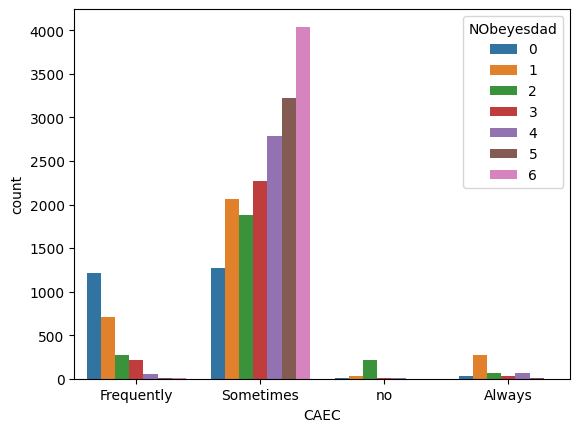

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='CAEC', hue='NObeyesdad', data=df_train)
plt.show()


In [79]:

# Create a new variable based on the condition
df_train['CAEC1'] = df_train['CAEC'].apply(lambda x: 2 if x == 'no' else (1 if x == 'Always' else (0 if x == 'Frequently' else 6)))
df_train['Gender1'] = df_train['Gender'].apply(lambda x: 6 if x == 'Female' else 5)




In [80]:
df_test['CAEC1'] = df_test['CAEC'].apply(lambda x: 2 if x == 'no' else (1 if x == 'Always' else (0 if x == 'Frequently' else 6)))
df_test['Gender1'] = df_test['Gender'].apply(lambda x: 6 if x == 'Female' else 5)


In [81]:
df=df_train

In [82]:
df1=df_test

In [83]:
df['Gender']

1        Female
2        Female
3        Female
4          Male
5          Male
          ...  
20753      Male
20754      Male
20755      Male
20756      Male
20757      Male
Name: Gender, Length: 20757, dtype: object

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20757 entries, 1 to 20757
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20757 non-null  int64  
 1   Gender                          20757 non-null  object 
 2   Age                             20757 non-null  float64
 3   Height                          20757 non-null  float64
 4   Weight                          20757 non-null  float64
 5   family_history_with_overweight  20757 non-null  object 
 6   FAVC                            20757 non-null  object 
 7   FCVC                            20757 non-null  float64
 8   NCP                             20757 non-null  float64
 9   CAEC                            20757 non-null  object 
 10  SMOKE                           20757 non-null  object 
 11  CH2O                            20757 non-null  float64
 12  SCC                             20757

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13839 entries, 1 to 13839
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13839 non-null  int64  
 1   Gender                          13839 non-null  object 
 2   Age                             13839 non-null  float64
 3   Height                          13839 non-null  float64
 4   Weight                          13839 non-null  float64
 5   family_history_with_overweight  13839 non-null  object 
 6   FAVC                            13839 non-null  object 
 7   FCVC                            13839 non-null  float64
 8   NCP                             13839 non-null  float64
 9   CAEC                            13839 non-null  object 
 10  SMOKE                           13839 non-null  object 
 11  CH2O                            13839 non-null  float64
 12  SCC                             13839

In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20757 entries, 1 to 20757
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20757 non-null  int64  
 1   Gender                          20757 non-null  object 
 2   Age                             20757 non-null  float64
 3   Height                          20757 non-null  float64
 4   Weight                          20757 non-null  float64
 5   family_history_with_overweight  20757 non-null  object 
 6   FAVC                            20757 non-null  object 
 7   FCVC                            20757 non-null  float64
 8   NCP                             20757 non-null  float64
 9   CAEC                            20757 non-null  object 
 10  SMOKE                           20757 non-null  object 
 11  CH2O                            20757 non-null  float64
 12  SCC                             20757

In [87]:

missing_columns_train = set(df.columns) - set(df1.columns)

# Get the columns present in df_test but not in df_train
missing_columns_test = set(df1.columns) - set(df.columns)

# Print the results
print("Missing columns in df_test from df:", missing_columns_train)
print("Missing columns in df_train from df1:", missing_columns_test)


Missing columns in df_test from df: {'NObeyesdad'}
Missing columns in df_train from df1: set()


In [88]:


# Specify columns to one-hot encode
columns_to_one_hot_encode = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Use pd.get_dummies to apply one-hot encoding to each specified column
df = pd.get_dummies(df, columns=columns_to_one_hot_encode)

# Display the updated DataFrame
print(df.head())


   id        Age    Height      Weight      FCVC       NCP      CH2O  \
1   1  18.000000  1.560000   57.000000  2.000000  3.000000  2.000000   
2   2  18.000000  1.711460   50.165754  1.880534  1.411685  1.910378   
3   3  20.952737  1.710730  131.274851  3.000000  3.000000  1.674061   
4   4  31.641081  1.914186   93.798055  2.679664  1.971472  1.979848   
5   5  18.128249  1.748524   51.552595  2.919751  3.000000  2.137550   

        FAF       TUE  NObeyesdad  ...  SCC_no  SCC_yes  CALC_Frequently  \
1  1.000000  1.000000           1  ...    True    False            False   
2  0.866045  1.673584           0  ...    True    False            False   
3  1.467863  0.780199           6  ...    True    False            False   
4  1.967973  0.931721           3  ...    True    False            False   
5  1.930033  1.000000           0  ...    True    False            False   

   CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
1           False     True    

In [89]:


# Specify columns to one-hot encode
columns_to_one_hot_encode = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Use pd.get_dummies to apply one-hot encoding to each specified column
df1 = pd.get_dummies(df1, columns=columns_to_one_hot_encode)

# Display the updated DataFrame
print(df_test.head())


      id  Gender        Age    Height      Weight  \
1  20759  Female  21.000000  1.600000   66.000000   
2  20760  Female  26.000000  1.643355  111.600553   
3  20761    Male  20.979254  1.553127  103.669116   
4  20762  Female  26.000000  1.627396  104.835346   
5  20763    Male  19.799054  1.844751   59.605028   

  family_history_with_overweight FAVC  FCVC       NCP       CAEC  ...  \
1                            yes  yes   2.0  1.000000  Sometimes  ...   
2                            yes  yes   3.0  3.000000  Sometimes  ...   
3                            yes  yes   2.0  2.977909  Sometimes  ...   
4                            yes  yes   3.0  3.000000  Sometimes  ...   
5                            yes  yes   2.0  4.000000  Sometimes  ...   

         BMI  Caloric_Intake Weight_Status_Score  Physical_Activity_Minutes  \
1  25.781250        9.000000           -0.818959                   0.000000   
2  41.324115        7.865631            0.927398                   0.000000   
3  42

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20757 entries, 1 to 20757
Data columns (total 51 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  20757 non-null  int64  
 1   Age                                 20757 non-null  float64
 2   Height                              20757 non-null  float64
 3   Weight                              20757 non-null  float64
 4   FCVC                                20757 non-null  float64
 5   NCP                                 20757 non-null  float64
 6   CH2O                                20757 non-null  float64
 7   FAF                                 20757 non-null  float64
 8   TUE                                 20757 non-null  float64
 9   NObeyesdad                          20757 non-null  int64  
 10  id_scaled                           20757 non-null  float64
 11  Age_scaled                          20757 non-

In [91]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13839 entries, 1 to 13839
Data columns (total 51 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  13839 non-null  int64  
 1   Age                                 13839 non-null  float64
 2   Height                              13839 non-null  float64
 3   Weight                              13839 non-null  float64
 4   FCVC                                13839 non-null  float64
 5   NCP                                 13839 non-null  float64
 6   CH2O                                13839 non-null  float64
 7   FAF                                 13839 non-null  float64
 8   TUE                                 13839 non-null  float64
 9   id_scaled                           13839 non-null  float64
 10  Age_scaled                          13839 non-null  float64
 11  Height_scaled                       13839 non-

In [92]:
df1=df1.drop(['id'],axis=1)

In [93]:
df.isna().sum()

id                                    0
Age                                   0
Height                                0
Weight                                0
FCVC                                  0
NCP                                   0
CH2O                                  0
FAF                                   0
TUE                                   0
NObeyesdad                            0
id_scaled                             0
Age_scaled                            0
Height_scaled                         0
Weight_scaled                         0
FCVC_scaled                           0
NCP_scaled                            0
CH2O_scaled                           0
FAF_scaled                            0
TUE_scaled                            0
BMI                                   0
Caloric_Intake                        0
Weight_Status_Score                   0
Physical_Activity_Minutes             0
Nutrient_Ratio                        0
Age_Weighted_BMI                      0


In [94]:
X=df.drop(['id','NObeyesdad'],axis=1)

In [95]:
y=df['NObeyesdad']

In [96]:

missing_columns_train = set(df.columns) - set(df1.columns)

# Get the columns present in df_test but not in df_train
missing_columns_test = set(df1.columns) - set(df.columns)

# Print the results
print("Missing columns in df_test from df:", missing_columns_train)
print("Missing columns in df_train from df1:", missing_columns_test)


Missing columns in df_test from df: {'id', 'NObeyesdad'}
Missing columns in df_train from df1: {'CALC_Always'}


In [97]:
df1=df1.drop(['CALC_Always'],axis=1)

In [98]:
X.shape,df1.shape

((20757, 49), (13839, 49))

In [99]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler,MinMaxScaler

# Assuming you have your features X and labels y as pandas DataFrame
# Make sure that X and y are pandas DataFrame

# Create a StratifiedKFold object with 5 folds
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create and fit the RobustScaler to the entire data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert X_scaled to DataFrame if it is not already
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Initialize an empty list to store the accuracy scores
accuracy_scores = []

# Loop through the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_scaled, y), 1):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create XGBoost classifier
    xgb_classifier = XGBClassifier()

    # Train the classifier on the scaled training data
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the scaled test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Print accuracy for each fold
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracy_scores)

print(f"\nMean Accuracy: {mean_accuracy:.4f}")


Fold 1 Accuracy: 0.9085
Fold 2 Accuracy: 0.9017
Fold 3 Accuracy: 0.8940
Fold 4 Accuracy: 0.9037
Fold 5 Accuracy: 0.9128
Fold 6 Accuracy: 0.9046
Fold 7 Accuracy: 0.9133
Fold 8 Accuracy: 0.9070
Fold 9 Accuracy: 0.9128
Fold 10 Accuracy: 0.9051

Mean Accuracy: 0.9063


In [101]:
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Ignore warnings
warnings.filterwarnings("ignore")

# Assuming you have your features X and labels y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Train the classifier on the training data
lgbm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.5f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6388
[LightGBM] [Info] Number of data points in the train set: 16605, number of used features: 49
[LightGBM] [Info] Start training from score -2.105122
[LightGBM] [Info] Start training from score -1.914841
[LightGBM] [Info] Start training from score -2.148563
[LightGBM] [Info] Start training from score -2.121067
[LightGBM] [Info] Start training from score -1.956566
[LightGBM] [Info] Start training from score -1.848440
[LightGBM] [Info] Start training from score -1.632589
Accuracy: 0.91209
